In [15]:
'''
Get a DSD model fit from OceanRain observed DSDs

OceanRain disdrometer observations are binned by observed raindrop size (D)
and given as number concentration (N).

'''



import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os
import cartopy.crs as ccrs
import datetime
from scipy.stats import gaussian_kde
import math
from matplotlib.colors import LogNorm

In [16]:
def marshall_palmer(lamb, D):

    N_0 = 8000

    N_MP = N_0 * np.exp(-lamb * D)
    
    return N_MP


def mp_lambda(R):
    return 4.1 * R**(-0.21)


def gamma(N_0, lamb, mu, D):
    return N_0 * (D**mu) * np.exp(-lamb * D)

def log_norm(N_t, eta, sigma, D):
    exp_term = -(np.log(D) - eta)**2 / (2*(sigma**2))
    return (N_t / (np.sqrt(2 * np.pi) * sigma * D)) * np.exp(exp_term)

def abel_boutle(lamb, D):
    
    x1 = 0.22
    x2 = 2.20
    
    N_0 = x1 * (lamb ** x2)
    
    N = N_0 * np.exp(-lamb * D)
    
    
    return N


def norm_gamma(N_0, lamb, mu, D):
    
    term1 = 6./(3.67**4.)
    term2 = ((3.67+mu)**(mu+4.)) / math.gamma(mu+4)
    
    f_mu = term1 * term2
    
    D_0 = ((3.67+mu)/lamb)
    N_w = N_0 / (f_mu*(D_0**(-mu)))
    
    return N_w * f_mu * (D/D_0)**mu * np.exp(-lamb*D)


def inverse_exponential(lamb, N_0, D):
    
    return N_0 * np.exp(-lamb * D)


def time_avg(dsd_obs, precip_rate, time, min_avg):
    
    window_half = min_avg // 2
    
    mean_dsd_obs      = np.zeros(dsd_obs.shape)
    mean_prcp_rate    = np.zeros(precip_rate.shape)
    mean_dsd_obs[:]   = -9999.9
    mean_prcp_rate[:] = -9999.9
    
    jtime = 0
    
    ntimes = time.size
    
    for itime in np.arange(0, ntimes):
        
        if itime < window_half:
            continue
            
        time_bound1 = itime - window_half
        time_bound2 = itime + window_half + 1
        
        beg_time = all_time[time_bound1]
        end_time = all_time[time_bound2]
        
        if (end_time - beg_time) > np.timedelta64(min_avg, 'm'):
            continue
            
        mean_dsd_obs[jtime,:]   = np.mean(dsd_obs[time_bound1:time_bound2,:], axis=0)
        mean_prcp_rate[jtime]   = np.mean(precip_rate[time_bound1:time_bound2], axis=0)
        
        jtime += 1
        
    mean_dsd_obs = mean_dsd_obs[:jtime,:]
    mean_prcp_rate = mean_prcp_rate[:jtime]
    
    return mean_dsd_obs, mean_prcp_rate



In [17]:
ocnr_dir = '/edata2/spencer/oceanRAIN/'

flist_R = glob(ocnr_dir+'/OceanRAIN-R*.nc')
flist_M = glob(ocnr_dir+'/OceanRAIN-M*.nc')
flist_R.sort()
flist_M.sort()

prcp_obs = []
all_prcp_obs = []

first = True

for ifile in flist_M:
    
    print(ifile)
    
    with xr.open_dataset(ifile) as f:
        
        lat = f.latitude.values
        lon = f.longitude.values
        
        obstime = f.time.values
    
        ntimes = obstime.size

        prain = f.probability_for_rain.values
        psnow = f.probability_for_snow.values
        pmxph = f.probability_for_mixed_phase.values
        pflg  = f.precip_flag.values  #Precip type
        pflg2 = f.precip_flag2.values #RR bin
        prcp  = f.ODM470_precipitation_rate_R.values

        nbins = 128

        prcp_obs    = np.zeros([ntimes,nbins])
        prcp_obs[:] = -9999.9
        
        
        
        if 'bin1' not in f.keys():
            print(f"No disdrometer obs for ", ifile)
            continue
            

        for i in np.arange(0,128):
            prcp_obs[:,i] = f['bin'+str(i+1)].values
            
            
        #---QC:
        not_high_lats = np.where(np.logical_and(lat > -40.0, lat < 40.0))
        bad_data      = np.where(pflg > 3)
        not_raining   = np.where(pflg2 < 12)
        
        prcp_obs[not_high_lats,:] = -9999.9
        prcp_obs[bad_data,:]      = -9999.9
        prcp_obs[not_raining,:]   = -9999.9
        
        indcs_to_delete = []
        
        for i in np.arange(0, ntimes):
            
            if np.all(prcp_obs[i,:] < 0.0):
                indcs_to_delete = np.append(indcs_to_delete, i)
                
        indcs_to_delete = indcs_to_delete.astype(int)
                
        prcp_obs = np.delete(prcp_obs, indcs_to_delete, axis=0)
        lat      = np.delete(lat, indcs_to_delete)
        lon      = np.delete(lon, indcs_to_delete)
        pflg     = np.delete(pflg, indcs_to_delete)
        pflg2    = np.delete(pflg2, indcs_to_delete)
        prcp_rate = np.delete(prcp, indcs_to_delete)
        obstime     = np.delete(obstime, indcs_to_delete)

        
        if first == True:
            all_prcp_obs = prcp_obs
            all_lat      = lat
            all_lon      = lon
            all_pflg     = pflg
            all_pflg2    = pflg2
            all_prcp_rate = prcp_rate
            all_time     = obstime
            first = False
            
        else:
            all_prcp_obs = np.concatenate((all_prcp_obs,prcp_obs), axis=0)
            all_lat      = np.concatenate((all_lat, lat))
            all_lon      = np.concatenate((all_lon, lon))
            all_pflg     = np.concatenate((all_pflg, pflg))
            all_pflg2    = np.concatenate((all_pflg2, pflg2))
            all_prcp_rate = np.concatenate((all_prcp_rate, prcp_rate))
            all_time     = np.concatenate((all_time, obstime))

all_pflg = all_pflg.astype('i')
all_pflg2 = all_pflg2.astype('i')

/edata2/spencer/oceanRAIN/OceanRAIN-M_MS-The-World_C6RW4_JAN2017-DEC2018_DWD-MPIM_V2_0.nc


/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/edata2/spencer/oceanRAIN/OceanRAIN-M_RV-Investigator_VLMJ_JAN2016-MAY2018_DWD-MPIM_V2_0.nc


/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/edata2/spencer/oceanRAIN/OceanRAIN-M_RV-Maria-S-Merian_DBBT_OCT2012-DEC2018_DWD-MPIM_V2_0.nc


/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/edata2/spencer/oceanRAIN/OceanRAIN-M_RV-Meteor_DBBH_MAR2014-DEC2018_DWD-MPIM_V2_0.nc


/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/edata2/spencer/oceanRAIN/OceanRAIN-M_RV-Polarstern_DBLK_JUN2010-DEC2018_DWD-MPIM_V2_0.nc


/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/edata2/spencer/oceanRAIN/OceanRAIN-M_RV-Roger-Revelle_KAOU_AUG2016-DEC2017_DWD-MPIM_V2_0.nc


/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/edata2/spencer/oceanRAIN/OceanRAIN-M_RV-SonneII_DBBE_NOV2014-DEC2018_DWD-MPIM_V2_0.nc


/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/edata2/spencer/oceanRAIN/OceanRAIN-M_RV-SonneI_DFCG_SEP2012-OCT2012_DWD-MPIM_V2_0.nc


/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [18]:
#---Separate rain, snow, mixed:
#precip_flag: 0 = rain, 1 = snow, 2 = mixed

rain = np.where(all_pflg == 0)
snow = np.where(all_pflg == 1)
mixed = np.where(all_pflg == 2)

all_rain_rate = all_prcp_rate[rain]
all_snow_rate = all_prcp_rate[snow]
all_mxph_rate = all_prcp_rate[mixed]

all_rain_obs = all_prcp_obs[rain]
all_snow_obs = all_prcp_obs[snow]
all_mxph_obs = all_prcp_obs[mixed]

all_rain_time = all_time[rain]
all_snow_time = all_time[snow]
all_mxph_time = all_time[mixed]

In [19]:
#---Take time-averaged means of DSD obs:

min_avg = 5

window_half = min_avg // 2

#Preallocate time-averaged DSD arrays
mean_dsd_obs_r = np.zeros(all_rain_obs.shape) #too large, but will trim at the end
mean_dsd_obs_s = np.zeros(all_snow_obs.shape)
mean_dsd_obs_m = np.zeros(all_mxph_obs.shape)
mean_dsd_obs_r[:] = -9999.9
mean_dsd_obs_s[:] = -9999.9
mean_dsd_obs_m[:] = -9999.9

#Preallocate arrays for time-averaged precip rate (for binning)
mean_rain_rate = np.zeros(all_rain_rate.shape)
mean_snow_rate = np.zeros(all_snow_rate.shape)
mean_mxph_rate = np.zeros(all_mxph_rate.shape)
mean_rain_rate[:] = -9999.9
mean_snow_rate[:] = -9999.9
mean_mxph_rate[:] = -9999.9


mean_dsd_obs_rain, mean_rain_rate = time_avg(all_rain_obs, all_rain_rate, all_rain_time, min_avg)
mean_dsd_obs_snow, mean_snow_rate = time_avg(all_snow_obs, all_snow_rate, all_snow_time, min_avg)

In [20]:
with xr.open_dataset(flist_M[0]) as f:
    D_str = []
    for i in np.arange(0,128):
        D_str = np.append(D_str,f['bin'+str(i+1)].attrs['long_name'][34:-2])
        
D = D_str.astype('f')
D

/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'relative_wind_speed_ODM470' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/local/anaconda/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'reference_voltage' has multiple fill values {-88.88, -99.99}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


array([ 0.0375,  0.0632,  0.0896,  0.1166,  0.1443,  0.1727,  0.2018,
        0.2316,  0.2621,  0.2934,  0.3255,  0.3583,  0.392 ,  0.4266,
        0.4619,  0.4982,  0.5353,  0.5734,  0.6124,  0.6524,  0.6934,
        0.7354,  0.7784,  0.8225,  0.8677,  0.914 ,  0.9615,  1.0101,
        1.06  ,  1.1111,  1.1634,  1.2171,  1.272 ,  1.3284,  1.3861,
        1.4453,  1.5059,  1.5681,  1.6318,  1.697 ,  1.7639,  1.8324,
        1.9027,  1.9747,  2.0484,  2.124 ,  2.2015,  2.2809,  2.3622,
        2.4456,  2.5311,  2.6186,  2.7084,  2.8003,  2.8946,  2.9911,
        3.0901,  3.1915,  3.2955,  3.402 ,  3.5112,  3.623 ,  3.7377,
        3.8552,  3.9755,  4.0989,  4.2254,  4.355 ,  4.4877,  4.6238,
        4.7633,  4.9062,  5.0527,  5.2028,  5.3566,  5.5142,  5.6758,
        5.8413,  6.011 ,  6.1848,  6.363 ,  6.5456,  6.7327,  6.9244,
        7.121 ,  7.3223,  7.5287,  7.7402,  7.957 ,  8.1791,  8.4067,
        8.64  ,  8.879 ,  9.124 ,  9.375 ,  9.6323,  9.896 , 10.1662,
       10.4431, 10.7

In [21]:
#---Separate into rr bins:
#bin1 = 0.0  - 0.09
#bin2 = 0.10 - 0.24
#bin3 = 0.25 - 0.49
#bin4 = 0.50 - 0.99
#bin5 = 1.0  - 1.99
#bin6 = 2.0  - 9.99

bin_lims = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def bin_by_rr(mean_prcp_rate, mean_dsd_obs, bin_edges):
    
    nbins = len(bin_edges) - 1
    
    binned_obs = {}
    
    binned_obs['rate'] = {}
    binned_obs['dsd_obs'] = {}
    
    for ibin in np.arange(0, nbins):
        
        within_bin = np.logical_and(mean_prcp_rate > bin_edges[ibin], 
                                    mean_prcp_rate <= bin_edges[ibin+1])
        
        indcs_for_bin = np.where(within_bin)
        
        binned_obs['rate']['bin'+str(ibin+1)] = mean_prcp_rate[indcs_for_bin]
        
        binned_obs['dsd_obs']['bin'+str(ibin+1)] = mean_dsd_obs[indcs_for_bin]

    
    return binned_obs

rain_obs = bin_by_rr(mean_rain_rate, mean_dsd_obs_rain, bin_lims)
snow_obs = bin_by_rr(mean_snow_rate, mean_dsd_obs_snow, bin_lims)

print('Number of rain obs in each bin: ')

for i,ibin in enumerate(rain_obs['rate'].keys()):
    print(ibin+':', rain_obs['rate'][ibin].size)

print('Number of snow obs in each bin: ')
for i,ibin in enumerate(snow_obs['rate'].keys()):
    print(ibin+':', snow_obs['rate'][ibin].size)

Number of rain obs in each bin: 
bin1: 47021
bin2: 29859
bin3: 20558
bin4: 15729
bin5: 12196
bin6: 9910
Number of snow obs in each bin: 
bin1: 69622
bin2: 20494
bin3: 10962
bin4: 7133
bin5: 5010
bin6: 3721


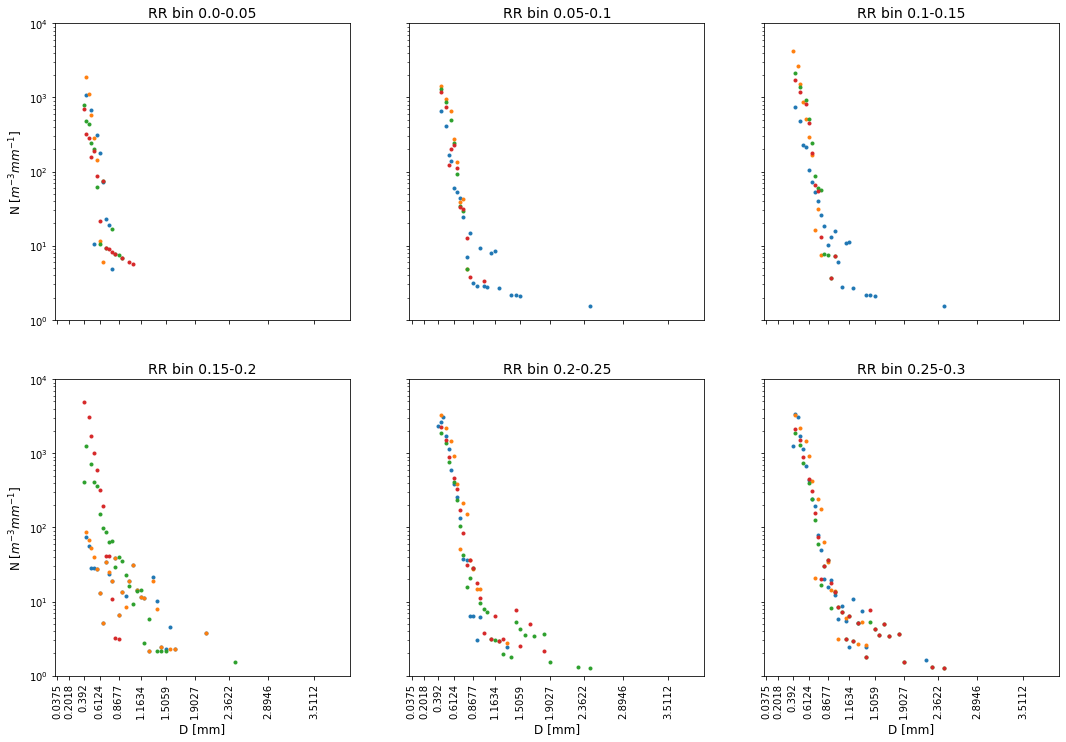

In [22]:
#---Plot each individual observation

max_obs = 3

fig, ax = plt.subplots(2, 3, figsize=[18,12], sharex=True, sharey=True)

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[0,2]
ax4 = ax[1,0]
ax5 = ax[1,1]
ax6 = ax[1,2]

ax1.set_xticks(D[::6], D_str[::6])
ax4.set_xticklabels(D_str[::6], rotation=90)
ax5.set_xticklabels(D_str[::6], rotation=90)
ax6.set_xticklabels(D_str[::6], rotation=90)
ax1.set_xlim(0, 4)

ax4.set_xlabel('D [mm]', fontsize=12)
ax5.set_xlabel('D [mm]', fontsize=12)
ax6.set_xlabel('D [mm]', fontsize=12)

ax1.set_ylabel('N [$m^{-3} mm^{-1}$]', fontsize=12)
ax4.set_ylabel('N [$m^{-3} mm^{-1}$]', fontsize=12)


ax1.set_yscale('log')
ax1.set_ylim(1,10**4)

nobs_bin1 = rain_obs['dsd_obs']['bin1'].size
nobs_bin2 = rain_obs['dsd_obs']['bin2'].size
nobs_bin3 = rain_obs['dsd_obs']['bin3'].size
nobs_bin4 = rain_obs['dsd_obs']['bin4'].size
nobs_bin5 = rain_obs['dsd_obs']['bin5'].size
nobs_bin6 = rain_obs['dsd_obs']['bin6'].size

    
x = []
y = []

for i in np.arange(0, nobs_bin1):
    
    ax1.plot(D, rain_obs['dsd_obs']['bin1'][i,:], marker='.', linestyle='')
    
    if i >= max_obs:
        break
    
x = []
y = []

for i in np.arange(0, nobs_bin2):
    
    ax2.plot(D, rain_obs['dsd_obs']['bin2'][i,:], marker='.', linestyle='')
    
    if i >= max_obs:
        break
    
    
x = []
y = []
for i in np.arange(0, nobs_bin3):
    
    ax3.plot(D, rain_obs['dsd_obs']['bin3'][i,:], marker='.', linestyle='')

    if i >= max_obs:
        break
        
x = []
y = []     
for i in np.arange(0, nobs_bin4):
    
    ax4.plot(D, rain_obs['dsd_obs']['bin4'][i,:], marker='.', linestyle='')

    if i >= max_obs:
        break
        
x = []
y = []   
for i in np.arange(0, nobs_bin5):

    ax5.plot(D, rain_obs['dsd_obs']['bin5'][i,:], marker='.', linestyle='')

    if i >= max_obs:
        break
        
x = []
y = []        
for i in np.arange(0, nobs_bin6):
    
    ax6.plot(D, rain_obs['dsd_obs']['bin6'][i,:], marker='.', linestyle='') 

    if i >= max_obs:
        break

        
        
#---Tunable parameters:

mu = 1.0
N_0 = 10000.0
        
        
# ax1.plot(D, marshall_palmer(lamb=mp_lamb1,D=D), linewidth=2, linestyle='--', color='k', 
#          label='Marshall & Palmer')
# ax2.plot(D, marshall_palmer(lamb=mp_lamb2,D=D), linewidth=2, linestyle='--', color='k')
# ax3.plot(D, marshall_palmer(lamb=mp_lamb3,D=D), linewidth=2, linestyle='--', color='k')
# ax4.plot(D, marshall_palmer(lamb=mp_lamb4,D=D), linewidth=2, linestyle='--', color='k')
# ax5.plot(D, marshall_palmer(lamb=mp_lamb5,D=D), linewidth=2, linestyle='--', color='k')
# ax6.plot(D, marshall_palmer(lamb=mp_lamb6,D=D), linewidth=2, linestyle='--', color='k')

# ax1.plot(D, gamma(N_0=N_0, lamb=0.2, mu=mu, D=D), linewidth=2, linestyle='--', color='blue', 
#          label='Gamma')
# ax2.plot(D, gamma(N_0=N_0, lamb=0.2, mu=mu, D=D), linewidth=2, linestyle='--', color='blue')
# ax3.plot(D, gamma(N_0=N_0, lamb=0.2, mu=mu, D=D), linewidth=2, linestyle='--', color='blue')
# ax4.plot(D, gamma(N_0=N_0, lamb=0.2, mu=mu, D=D), linewidth=2, linestyle='--', color='blue')
# ax5.plot(D, gamma(N_0=N_0, lamb=0.2, mu=mu, D=D), linewidth=2, linestyle='--', color='blue')
# ax6.plot(D, gamma(N_0=N_0, lamb=0.2, mu=mu, D=D), linewidth=2, linestyle='--', color='blue')

# ax1.plot(D, log_norm(N_t=3000, eta=-2.0, sigma=0.55, D=D), color='magenta', linewidth=1.75, linestyle='--',
#          label='Log Normal')
# ax2.plot(D, log_norm(N_t=3000, eta=-2.0, sigma=0.65, D=D), color='magenta', linewidth=1.75, linestyle='--')
# ax3.plot(D, log_norm(N_t=3000, eta=-2.0, sigma=0.75, D=D), color='magenta', linewidth=1.75, linestyle='--')
# ax4.plot(D, log_norm(N_t=3000, eta=-2.0, sigma=0.85, D=D), color='magenta', linewidth=1.75, linestyle='--')
# ax5.plot(D, log_norm(N_t=3000, eta=-2.0, sigma=0.95, D=D), color='magenta', linewidth=1.75, linestyle='--')
# ax6.plot(D, log_norm(N_t=3000, eta=-2.0, sigma=1.05, D=D), color='magenta', linewidth=1.75, linestyle='--')

ax1.set_title('RR bin '+str(bin_lims[0])+'-'+str(bin_lims[1]), fontsize=14)
ax2.set_title('RR bin '+str(bin_lims[1])+'-'+str(bin_lims[2]), fontsize=14)
ax3.set_title('RR bin '+str(bin_lims[2])+'-'+str(bin_lims[3]), fontsize=14)
ax4.set_title('RR bin '+str(bin_lims[3])+'-'+str(bin_lims[4]), fontsize=14)
ax5.set_title('RR bin '+str(bin_lims[4])+'-'+str(bin_lims[5]), fontsize=14)
ax6.set_title('RR bin '+str(bin_lims[5])+'-'+str(bin_lims[6]), fontsize=14)



plt.show()

/tmp/ipykernel_839340/3816359848.py:39: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y)
/tmp/ipykernel_839340/3816359848.py:55: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(gamma(N_0=N_0_1, lamb=lamb1, mu=mu1, D=D)),
/tmp/ipykernel_839340/3816359848.py:58: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(gamma(N_0=N_0_2, lamb=lamb2, mu=mu2, D=D)),
/tmp/ipykernel_839340/3816359848.py:55: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(gamma(N_0=N_0_1, lamb=lamb1, mu=mu1, D=D)),
/tmp/ipykernel_839340/3816359848.py:58: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(gamma(N_0=N_0_2, lamb=lamb2, mu=mu2, D=D)),
/tmp/ipykernel_839340/3816359848.py:55: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(gamma(N_0=N_0_1, lamb=lamb1, mu=mu1, D=D)),
/tmp/ipykernel_839340/3816359848.py:58: Runti

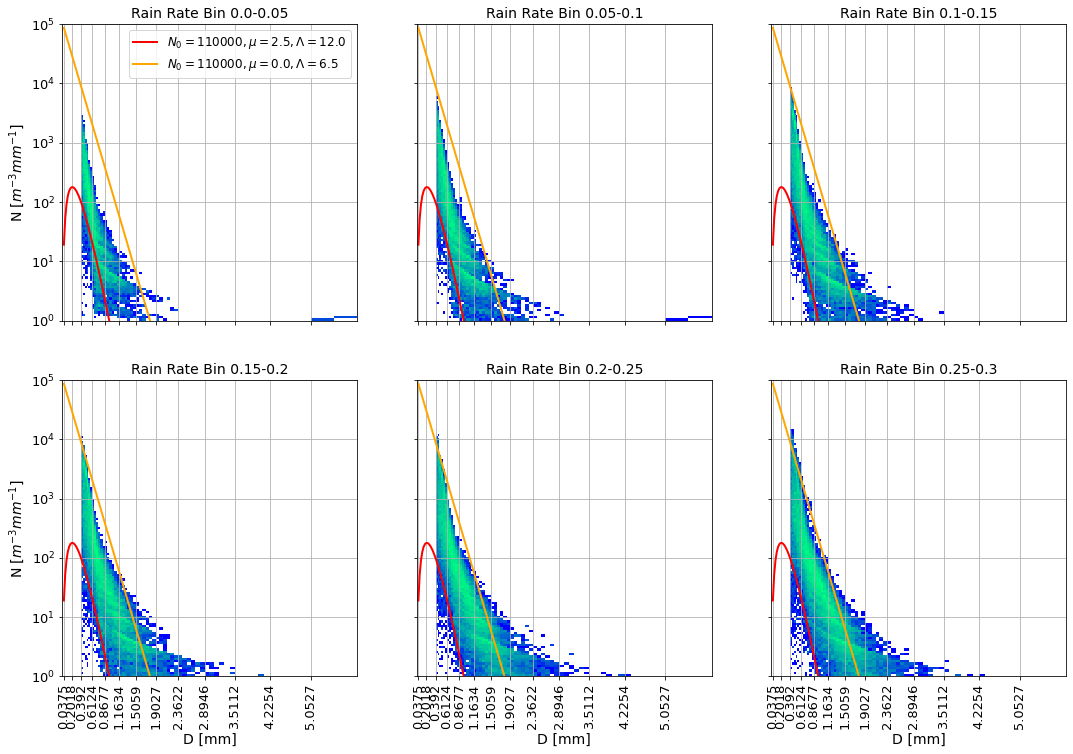

In [23]:
#------------------------------------------------------
#
#   RAIN
#
#------------------------------------------------------


max_obs = 2000

fig, ax = plt.subplots(2, 3, figsize=[18,12], sharex=True, sharey=True)


nobs_bin1 = rain_obs['dsd_obs']['bin1'].size
nobs_bin2 = rain_obs['dsd_obs']['bin2'].size
nobs_bin3 = rain_obs['dsd_obs']['bin3'].size
nobs_bin4 = rain_obs['dsd_obs']['bin4'].size
nobs_bin5 = rain_obs['dsd_obs']['bin5'].size
nobs_bin6 = rain_obs['dsd_obs']['bin6'].size


x_edges = D
y_edges = np.linspace(0,5, D.size)

cmap = 'winter'

j = 0
for irow in np.arange(0,2):
    for icol in np.arange(0,3):
        j = j + 1
        x = []
        y = []
        for i in np.arange(0, nobs_bin1):
            x = np.append(x, D)
            y = np.append(y, rain_obs['dsd_obs'][f'bin{j}'][i,:])
            
            if i >= max_obs:
                break
        
        y = np.log10(y)
        
        ax[irow,icol].hist2d(x, y, range=[[0,4],[0,5]], bins=[x_edges,y_edges], 
                             cmap='winter', norm=LogNorm())



N_0_1 = 110000
N_0_2 = 110000
lamb1 = 12.0
lamb2 = 6.5
mu1 = 2.5
mu2 = 0.0

for irow in np.arange(0,2):
    for icol in np.arange(0,3):
        ax[irow,icol].plot(D, np.log10(gamma(N_0=N_0_1, lamb=lamb1, mu=mu1, D=D)), 
                           color='red', linewidth=2.0, 
                           label=f'$N_0 = {N_0_1}, \mu = {mu1},\Lambda = {lamb1}$')
        ax[irow,icol].plot(D, np.log10(gamma(N_0=N_0_2, lamb=lamb2, mu=mu2, D=D)), 
                           color='orange', linewidth=2.0, 
                           label=f'$N_0 = {N_0_2}, \mu = {mu2}, \Lambda = {lamb2}$')


ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[0,2]
ax4 = ax[1,0]
ax5 = ax[1,1]
ax6 = ax[1,2]


ax1.set_xticks(D[::6], D_str[::6], fontsize=12)
ax4.set_xticklabels(D_str[::6], rotation=90)
ax5.set_xticklabels(D_str[::6], rotation=90)
ax6.set_xticklabels(D_str[::6], rotation=90)
ax1.set_xlim(0, 6)

ax1.set_yticks(np.arange(0,6,1), [f'$10^{i}$' for i in np.arange(0,6,1)])

ax1.tick_params(labelsize=13)
ax4.tick_params(labelsize=13)
ax5.tick_params(labelsize=13)
ax6.tick_params(labelsize=13)

ax4.set_xlabel('D [mm]', fontsize=14)
ax5.set_xlabel('D [mm]', fontsize=14)
ax6.set_xlabel('D [mm]', fontsize=14)

ax1.set_ylabel('N [$m^{-3} mm^{-1}$]', fontsize=14)
ax4.set_ylabel('N [$m^{-3} mm^{-1}$]', fontsize=14)


ax1.set_title('Rain Rate Bin '+str(bin_lims[0])+'-'+str(bin_lims[1]), fontsize=14)
ax2.set_title('Rain Rate Bin '+str(bin_lims[1])+'-'+str(bin_lims[2]), fontsize=14)
ax3.set_title('Rain Rate Bin '+str(bin_lims[2])+'-'+str(bin_lims[3]), fontsize=14)
ax4.set_title('Rain Rate Bin '+str(bin_lims[3])+'-'+str(bin_lims[4]), fontsize=14)
ax5.set_title('Rain Rate Bin '+str(bin_lims[4])+'-'+str(bin_lims[5]), fontsize=14)
ax6.set_title('Rain Rate Bin '+str(bin_lims[5])+'-'+str(bin_lims[6]), fontsize=14)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

ax1.legend(fontsize=12)
plt.show()

/tmp/ipykernel_839340/2410397511.py:39: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y)
/tmp/ipykernel_839340/2410397511.py:53: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(inverse_exponential(N_0=N_0_1, lamb=lamb1, D=D)),
/tmp/ipykernel_839340/2410397511.py:53: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(inverse_exponential(N_0=N_0_1, lamb=lamb1, D=D)),
/tmp/ipykernel_839340/2410397511.py:53: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(inverse_exponential(N_0=N_0_1, lamb=lamb1, D=D)),
/tmp/ipykernel_839340/2410397511.py:53: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(inverse_exponential(N_0=N_0_1, lamb=lamb1, D=D)),
/tmp/ipykernel_839340/2410397511.py:53: RuntimeWarning: divide by zero encountered in log10
  ax[irow,icol].plot(D, np.log10(inverse_exponential(N_0=N_0_1, lamb=lamb1, D=D)),
/tmp/ipykernel_

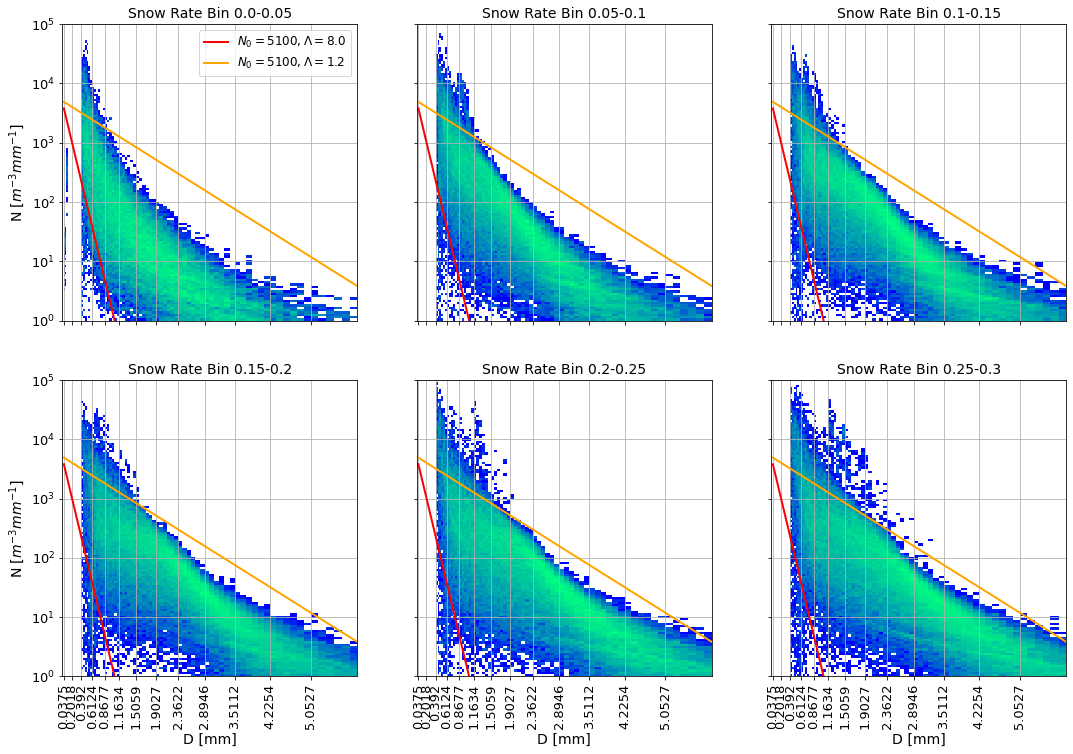

In [24]:
#------------------------------------------------------
#
#   SNOW
#
#------------------------------------------------------


max_obs = 2000

fig, ax = plt.subplots(2, 3, figsize=[18,12], sharex=True, sharey=True)


nobs_bin1 = snow_obs['dsd_obs']['bin1'].size
nobs_bin2 = snow_obs['dsd_obs']['bin2'].size
nobs_bin3 = snow_obs['dsd_obs']['bin3'].size
nobs_bin4 = snow_obs['dsd_obs']['bin4'].size
nobs_bin5 = snow_obs['dsd_obs']['bin5'].size
nobs_bin6 = snow_obs['dsd_obs']['bin6'].size


x_edges = D
y_edges = np.linspace(0,5, D.size)

cmap = 'winter'

j = 0
for irow in np.arange(0,2):
    for icol in np.arange(0,3):
        j = j + 1
        x = []
        y = []
        for i in np.arange(0, nobs_bin1):
            x = np.append(x, D)
            y = np.append(y, snow_obs['dsd_obs'][f'bin{j}'][i,:])
            
            if i >= max_obs:
                break
        
        y = np.log10(y)
        
        ax[irow,icol].hist2d(x, y, range=[[0,4],[0,5]], bins=[x_edges,y_edges], 
                             cmap='winter', norm=LogNorm())



N_0_1 = 5100
N_0_2 = 5100
lamb1 = 8.0
lamb2 = 1.2

for irow in np.arange(0,2):
    for icol in np.arange(0,3):
        ax[irow,icol].plot(D, np.log10(inverse_exponential(N_0=N_0_1, lamb=lamb1, D=D)), 
                           color='red', linewidth=2.0, label=f'$N_0 = {N_0_1}, \Lambda = {lamb1}$')
        ax[irow,icol].plot(D, np.log10(inverse_exponential(N_0=N_0_2, lamb=lamb2, D=D)), 
                           color='orange', linewidth=2.0, label=f'$N_0 = {N_0_2}, \Lambda = {lamb2}$')


ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[0,2]
ax4 = ax[1,0]
ax5 = ax[1,1]
ax6 = ax[1,2]


ax1.set_xticks(D[::6], D_str[::6], fontsize=12)
ax4.set_xticklabels(D_str[::6], rotation=90)
ax5.set_xticklabels(D_str[::6], rotation=90)
ax6.set_xticklabels(D_str[::6], rotation=90)
ax1.set_xlim(0, 6)

ax1.set_yticks(np.arange(0,6,1), [f'$10^{i}$' for i in np.arange(0,6,1)])

ax1.tick_params(labelsize=13)
ax4.tick_params(labelsize=13)
ax5.tick_params(labelsize=13)
ax6.tick_params(labelsize=13)

ax4.set_xlabel('D [mm]', fontsize=14)
ax5.set_xlabel('D [mm]', fontsize=14)
ax6.set_xlabel('D [mm]', fontsize=14)

ax1.set_ylabel('N [$m^{-3} mm^{-1}$]', fontsize=14)
ax4.set_ylabel('N [$m^{-3} mm^{-1}$]', fontsize=14)


ax1.set_title('Snow Rate Bin '+str(bin_lims[0])+'-'+str(bin_lims[1]), fontsize=14)
ax2.set_title('Snow Rate Bin '+str(bin_lims[1])+'-'+str(bin_lims[2]), fontsize=14)
ax3.set_title('Snow Rate Bin '+str(bin_lims[2])+'-'+str(bin_lims[3]), fontsize=14)
ax4.set_title('Snow Rate Bin '+str(bin_lims[3])+'-'+str(bin_lims[4]), fontsize=14)
ax5.set_title('Snow Rate Bin '+str(bin_lims[4])+'-'+str(bin_lims[5]), fontsize=14)
ax6.set_title('Snow Rate Bin '+str(bin_lims[5])+'-'+str(bin_lims[6]), fontsize=14)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

ax1.legend(fontsize=12)
plt.show()